# Forcing with model output

### This example is most useful for people with access to Australia's National Computational Infrastructure facility, because the model output being used is hosted here. For others, the 'reanalysis-forced' example will be more helpful as it relies only on open source data.

In [1]:
import numpy as np
from itertools import cycle
import os
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload


## For NCI users, uncomment the following line if you just want to import from my copy of the code and sidestep the installation process
## In this case just use the latest version of the analysis env. HOWEVER! Note that without the latest version of xesmf which is not yet
## available on analysis3, the regridding will only work in serial and won't be suitable for large domains

# os.chdir("/home/149/ab8992/cosima_regional/regional-mom6/")

import regional_mom6 as rm
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:43307' processes=4 threads=16, memory=64.00 GiB>

## What does this package do?

Setting up a regional model in MOM6 is a pain. The goal of this package is that users should spend their debugging time fixing a model that's running and doing weird things, rather than puzzling over a model that won't even start.

In running this notebook, you'll hopefully have a running MOM6 regional model. There will still be a lot of fiddling to do with the MOM_input file to make sure that the parameters are set up right for your domain, and you might want to manually edit some of the input files. BUT, this package should help you bypass most of the woes of regridding, encoding and understanding the arcane arts of the MOM6 boundary segment files. 


## What does this notebook do?

This notebook demonstrates how to set up a regional domain using the package. By the end you should have a running MOM6 experiment on the domain of your choice. To make a stable test case:

* Avoid any regions with ice
* Avoid regions near the north pole
* Although the default configuration is meant to be RYF, I've not fixed up the calendar and encoding to run longer than a year just yet


Input Type | Source
---|---
Surface | JRA 
Ocean | ACCESS OM2-01
Bathymetry | Gebco

## Step 0: Your personal environment variables

In [2]:
scratch = "/scratch/v45/ab8992"
home = "/home/149/ab8992"

## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! There's some troubleshooting you can do if not (check readme / readthedocs)

To find the lat/lon of the domain you want to test you can use <a href="https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download" > this GUI </a> and copy paste below

In [12]:
expt_name = "tasmania-example"

## Choose your coordinates and the name of your experiment
yextent = [-48,-38.95] ## latitude
xextent = [143,150] ## longitude

daterange = ["1990-01-01 00:00:00", "1990-01-05 00:00:00"] ## 2003 is a good compromise for GLORYs and JRA forcing as they overlap. JRA ends in 2012, GLORYS starts in 1993

## Place where all your input files go
inputdir = f"{scratch}/regional_mom6_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"{home}/mom6_rundirs/{expt_name}/"

## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables

## Directory where raw downloads go before processing
tmpdir = f"{scratch}/regional_tmp/{expt_name}"

for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)




## Step 2: Prepare ocean forcing data

We need to cut out our ocean forcing. The pipeline expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is "east_unprocessed" and "ic_unprocessed" for initial condition. The following provides an example for cutting out the necessary forcing files from an ocean model. It's hardcoded to pull data from a Repeat Year Forced ACCESS-OM2-01 database, but you should be able to recycle parts of the code to cut out data from a dataset of your choice


If you have access to where it's located on Gadi, you can execute the following cell to cut out and save your segments and use these instead. The default I've set it at below is to cut out 3 months. To cut out a year, uncomment the code above which concatenates several input files together. Keep in mind that these input files are HUGE and they'll take a while to open and processes. To do a whole year, you'll want to run with a whole node and go make yourself a cup of coffee (and maybe read the paper for a bit). 

The advantage of doing this though is that the input files that the pipeline has to deal with are a lot smaller, making subsequent computation a lot quicker. An older iteration of the boundary brushcutter was to read data directly from the huge datasets, but this required some very careful chunking to not break your kernel. 

**NOTE: I haven't automated this properly and it's hardcoded for the year of 1990, which corresponds to files 1077 - 1082. Could maybe use COSIMA cookbook for this step instead?**

In [6]:

########## TWO OPTIONS: ############################

## Use this if you want to do a quick test for up to 3 months
om2_input = xr.open_mfdataset(f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean_daily*",parallel=True,chunks='auto')[["u","v","salt","temp","eta_t"]].sel(    
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
).isel(time = slice(0,5))
## Use this to cut out entire year 
# om2_input = xr.concat(
#     [xr.open_mfdataset(f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output{i}/ocean/ocean_daily*",decode_times = False,parallel=True,chunks='auto') for i in range(1077,1082)],
#     "time"
# )
#!  for i in range(1077,1082) is hardcoded to choose the year of 1990 Jan -> Dec 31. 
#######################################################

# Cut out initial condition and save
ic = om2_input.isel(time = 0)

## Nicer Slicer handles seams in longitude and different grids. Ensures that the output matches our 'xextent'
ic = rm.nicer_slicer(ic,[xextent[0],xextent[1]],["xu_ocean","xt_ocean"])
ic.to_netcdf(tmpdir + "/ic_unprocessed")

## Cut out East and West segments. Does lat slice first then uses nicer slicer for lon slice
eastwest = om2_input.sel(    
    yu_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[1] + 0.2)
)
rm.nicer_slicer(eastwest,[xextent[1],xextent[1]],["xu_ocean","xt_ocean"]).to_netcdf(tmpdir + "/east_unprocessed")
rm.nicer_slicer(eastwest,[xextent[0],xextent[0]],["xu_ocean","xt_ocean"]).to_netcdf(tmpdir + "/west_unprocessed")

## Cut out North and South segments
northsouth = rm.nicer_slicer(om2_input,[xextent[0],xextent[1]],["xu_ocean","xt_ocean"])
northsouth.sel(
    yu_ocean = slice(yextent[1] - 0.2,yextent[1] + 0.2),
    yt_ocean = slice(yextent[1] - 0.2,yextent[1] + 0.2)
).to_netcdf(tmpdir + "/north_unprocessed")
northsouth.sel(
    yu_ocean = slice(yextent[0] - 0.2,yextent[0] + 0.2),
    yt_ocean = slice(yextent[0] - 0.2,yextent[0] + 0.2)
).to_netcdf(tmpdir + "/south_unprocessed")

## Step 3: Make experiment object
This object keeps track of your domain basics, as well as generating the hgrid, vgrid and setting up the folder structures. 

After running you can have a look at your grids by calling `expt.hgrid` and `expt.vgrid`

Plotting vgrid with marker = '.' option lets you see the spacing, or plotting 
```python
np.diff(expt.hgrid.zl).plot(marker = '.')
```
 shows you the vertical spacing profile.

### Modular workflow!

After constructing your expt object, if you don't like my lazy default hgrid and vgrid you can simply modify and overwrite them. However, you'll also need to save them to disk again as I've not automated this just yet. For example:

```python
expt.hgrid = custom_hgrid
expt.hgrid.to_netcdf(f"{inputdir}/hgrid.nc")
```

In [15]:
reload(rm)
expt = rm.experiment(
    xextent,
    yextent,
    daterange,
    0.05,  # Resolution
    75,    # Number of vertical layers
    10,    # Ratio of largest to smallest vertical layer. Select 1 for linear, negative number for higher resolution at bottom
    4500,  # Depth of simulation
    rundir,
    inputdir,
    toolpath
)

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
FRE TOOLS: Make solo mosaic


CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)


## Step 4: Set up bathymetry

Similarly to ocean forcing, we point our 'bathymetry' method at the location of the file of choice, and pass it a dictionary mapping variable names. This time we don't need to preprocess the topography since it's just a 2D field and easier to deal with. Afterwards you can run `expt.topog` and have a look at your domain. After running this cell, your input directory will contain other topography - adjacent things like the ocean mosaic and mask table too. This defaults to a 10x10 layout which can be updated later.

In [16]:
expt.bathymetry(
    '/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    {"xh":"lon",
     "yh":"lat",
     "elevation":"elevation"}, ## Again this dictionary just maps mom6 variable names to what they are in your topog.
     minimum_layers = 1
    )

 Starting weight generation with these inputs: 
   Source File: bathy_original.nc
   Destination File: topog_raw.nc
   Source variable names: elevation
   Destination variable names: elevation
   Souce Grid has a mask, using missingvalue    1.0000000000000000E+020
   Source File is in GRIDSPEC format with coordinate names lon lat
   Source Grid is a regional grid
   Destination File is in GRIDSPEC format with coordinate names lon lat
   Destination Grid is a regional grid
   Regrid Method: bilinear
   Pole option: NONE

 Completed file regrid successfully.

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = topog.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is solid_walls

==>NOTE

### Check out your domain:

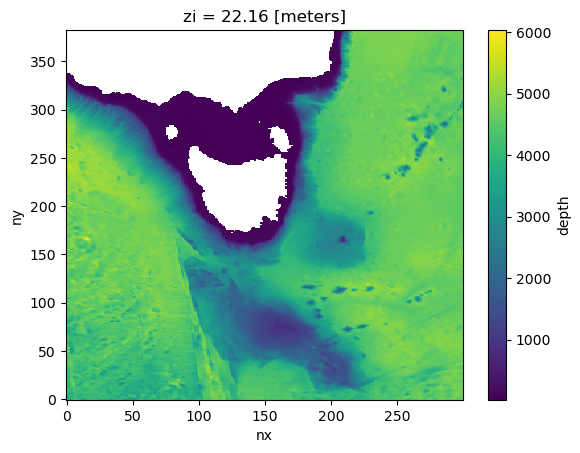

In [17]:
expt.topog.depth.plot()

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how the horizontal dimensions are x and y, vs xh, yh, xq, yq. This is because ACCESS-OM2-01 is on a `B` grid, so we need to differentiate between `q` and `t` points. 

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations. 


In [ ]:
## FOR ACCESS OM2: 
expt.ocean_forcing(
    tmpdir,  ## Path to ocean foring files
    {"time":"time",
     "yh":"yt_ocean",
     "xh":"xt_ocean",
     "xq":"xu_ocean",
     "yq":"yu_ocean",
     "zl":"st_ocean",
     "eta":"eta_t",
     "u":"u",
     "v":"v",
     "tracers":{"salt":"salt","temp":"temp"}},
    boundaries = ["south","north","west","east"],
    gridtype="B"
    )

## Step 6 Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're saying that we want a 10 by 10 grid of 100 processors. 

In [ ]:
expt.FRE_tools((10,10))


## Step 7: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This cell just copies a default run directory and modifies it to match your configuration.



In [11]:
subprocess.run(f"cp default_rundir/jra_surface/* {rundir} -r",shell = True)
subprocess.run(f"ln -s {inputdir} {rundir}/inputdir",shell=True)

hgrid = xr.open_dataset(f"{inputdir}/hgrid.nc")

## Get mask table information
ncpus = 10
mask_table = None
for i in os.listdir(f"{inputdir}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'

    if "NIGLOBAL" in lines[i]: 
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"

        
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"

        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        # lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        lines[i] = f"NIGLOBAL = {hgrid.nx.shape[0]//2}\n"
    if "LAYOUT =" in lines[i] and "IO" not in lines[i]:
        lines[i] = f'LAYOUT = {expt.layout[1]},{expt.layout[0]}\n'
    if "NJGLOBAL" in lines[i]:
        # lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        lines[i] = f"NJGLOBAL = {hgrid.ny.shape[0]//2}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml 
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: {str(ncpus)}\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {inputdir}\n"

inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()


# Modify input.nml 
inputfile = open(f"{rundir}/input.nml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "current_date" in lines[i]:
        tmp = daterange[0].split(" ")[0].split("-")
        lines[i] = f"{lines[i].split(' = ')[0]} = {int(tmp[0])},{int(tmp[1])},{int(tmp[2])},0,0,0,\n"

 
inputfile = open(f"{rundir}/input.nml",'w')
inputfile.writelines(lines)
inputfile.close()


ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/tasmania-september20-23//inputdir/tasmania-september20-23': File exists


## Step 8: Run your model!

To do this, navigate to your run directory in terminal. If you're working on NCI, you can do this via:

```
module load conda/analysis3
payu setup -f
payu run -f
```

By default `input.nml` is set to only run for 5 days as a test. If this is successful, you can modify this file to then run for longer.



## Step 9 and beyond: Fiddling, troubleshooting and fine tuning

Hopefully your model is running. If not, the first thing you should do is reduce the timestep. You can do this by adding `#override DT=XXXX` to your `MOM_override` file. 

If there's strange behaviour on your boundaries, you could play around with the `nudging timescale` (an example is already included in the `MOM_override` file). Sometimes, if your boundary has a lot going on (like all of the eddies spinning off the ACC), it can be hard to avoid these edge effects. This is because the chaotic, submesoscale structures developed within the regional domain won't match those at the boundary. 